In [1]:
import pandas as pd 
df = pd.read_excel("C:/Users/Patrick/Documents/projects/EnergyForecasting/dta/final_dta.xlsx")
df

,date,hour,price,hr1predisp,hr2predisp,hr3predisp,or10minsync,or10minnonsync,or30min,torontoTemp,ottawaTemp,datetime
0,2022-01-01,1,32.18,27.75,27.73,32.41,1.19,0.20,0.20,3.4,-2.0,2022-01-01T00:00
1,2022-01-01,2,59.04,23.23,28.62,32.41,1.30,0.20,0.20,2.9,-1.7,2022-01-01T01:00
2,2022-01-01,3,18.79,17.00,14.36,29.13,1.21,0.20,0.20,3.2,-1.8,2022-01-01T02:00
3,2022-01-01,4,15.78,18.00,17.20,14.39,1.22,0.20,0.20,3.2,-1.4,2022-01-01T03:00
4,2022-01-01,5,0.41,12.99,12.99,29.51,1.23,0.20,0.20,3.3,-1.1,2022-01-01T04:00
...,...,...,...,...,...,...,...,...,...,...,...,...
17515,2023-12-31,20,32.73,35.23,35.53,31.21,1.65,0.73,0.73,0.4,-4.8,2023-12-31T19:00
17516,2023-12-31,21,30.38,34.07,34.00,31.20,2.04,0.15,0.15,0.3,-4.7,2023-12-31T20:00
17517,2023-12-31,22,27.12,31.20,31.20,33.08,1.24,0.15,0.15,0.2,-5.9,2023-12-31T21:00
17518,2023-12-31,23,27.27,28.00,27.50,31.21,1.24,0.15,0.15,0.2,-6.3,2023-12-31T22:00


In [2]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['price'])
# Output the results
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# Print critical values
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -9.031757581813988
p-value: 5.4212036024260754e-15
Critical Values:
   1%: -3.4307242638530675
   5%: -2.861705410152796
   10%: -2.5668580435332715


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Separate dataframe into 3 sets: train, test and validation set
train_df, test_df = train_test_split(df, test_size=0.3, shuffle=False)


In [4]:
import pmdarima as pm
import numpy as np
model = pm.auto_arima(train_df['price'])
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                12264
Model:               SARIMAX(2, 1, 2)   Log Likelihood              -55686.381
Date:                Sun, 09 Jun 2024   AIC                         111382.762
Time:                        16:19:31   BIC                         111419.833
Sample:                             0   HQIC                        111395.184
                              - 12264                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9572      0.042     22.585      0.000       0.874       1.040
ar.L2         -0.1571      0.025     -6.351      0.000      -0.206      -0.109
ma.L1         -1.4151      0.042    -33.584      0.0

In [5]:
def rolling_forecast(model, train, test):
    forecast = []
    
    for i in range(len(test)):
        # Start with the model's n+1 forecast
        forecast.append(model.predict())

        # Add next value from validition data, re-fit and predict next
        train.append(test[i]) 
        del train[0]
        model.fit(train)

    return forecast    

In [6]:
train_list =  train_df['price'].to_list()
test_list = test_df['price'].to_list()

rolling_preds = rolling_forecast(model, train = train_list, test = test_list)

In [7]:
y_hat = []
y_hat.append(rolling_preds[0].iloc[0])

for i in range(1, len(rolling_preds)):
    y_hat.append(rolling_preds[i][0])

test_df['yhat'] = y_hat

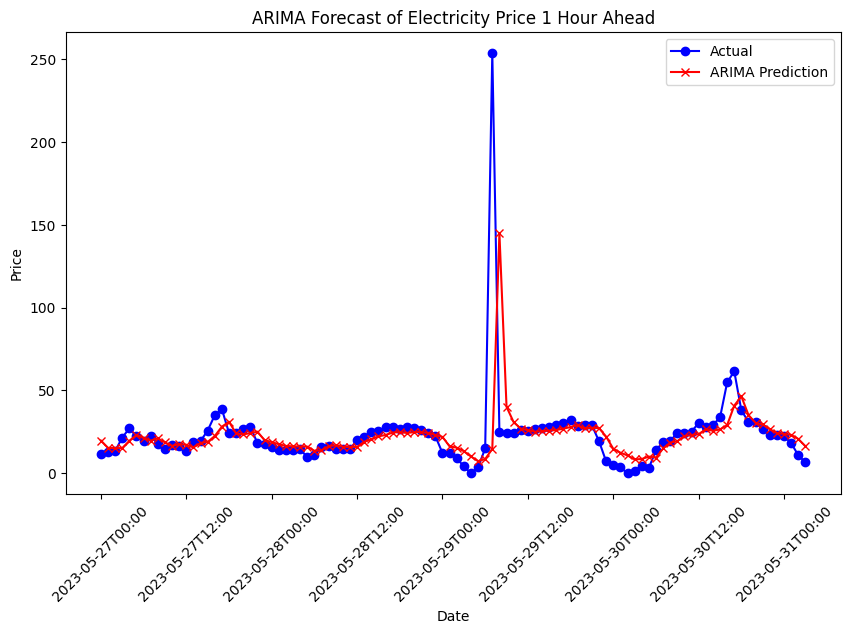

In [8]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 6))

# Plotting the 'Sales' line graph
plt.plot(test_df['datetime'].iloc[0:100], test_df['price'].iloc[0:100], marker='o', color='blue', label='Actual')

# Plotting the 'Expenses' line graph
plt.plot(test_df['datetime'].iloc[0:100], test_df['yhat'].iloc[0:100], marker='x', color='red', label='ARIMA Prediction')

# Adding title and labels
plt.title('ARIMA Forecast of Electricity Price 1 Hour Ahead')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(test_df['datetime'].iloc[0:100][::12], rotation=45)

# Adding legend
plt.legend()

# Displaying the plot
plt.grid(False)
plt.show()

In [14]:
rmse_arima = np.sqrt(((test_df['price'] - test_df['yhat']) ** 2).mean())
rmse_arima

18.268234605135348